#Introduction

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/My Drive/Colab Notebooks/CNN/CIFAR10_Classifier
%pwd

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/CNN/CIFAR10_Classifier


'/content/drive/My Drive/Colab Notebooks/CNN/CIFAR10_Classifier'

Import Libraries

In [2]:
from src.data.make_dataset import load_data, data_augmenter
#from src.models.train_model import AlexNet, AlexNetNorm
from src.models.predict_model import report, make_prediction
from src.models.visualize import plot_metrics, display_confusion_matrix, plotmodel, visualize_layers, visualize_predictions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import (
    Input,
    Add,
    Dense,
    Activation,
    ZeroPadding2D,
    Flatten,
    Conv2D,
    MaxPooling2D,
    AvgPool2D,
    AveragePooling2D,
    Dropout,
    BatchNormalization,
)
from keras.models import Sequential, Model, load_model
from keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    CSVLogger,
    LearningRateScheduler,
    TensorBoard
)
from keras import optimizers
from keras.regularizers import l2

#CIFAR-10


CIFAR-10 is a dataset of 60,000 32x32 color images in 10 different classes, with 6000 images per class. It is a widely used benchmark for machine learning and computer vision research, particularly in the area of image classification. The dataset consists of images of airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

It became a popular benchmark for machine learning research due to its small size, balanced classes and varied images

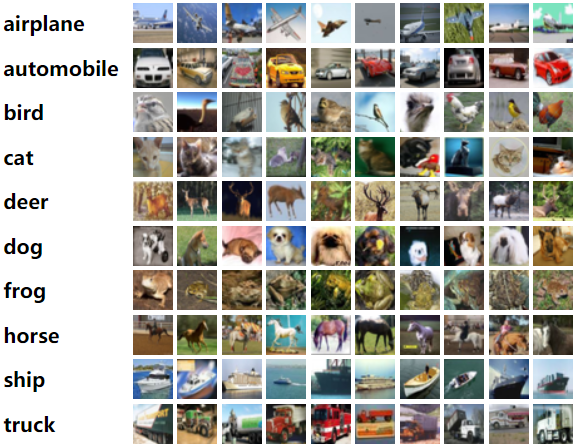

In [5]:
(x_train, y_train), (x_test, y_test), classes = load_data()

[Info] Loading CIFAR10 dataset ...
[Info] Dataset loaded
number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)
Classes:  {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


#Exploratory data analysis (EDA)

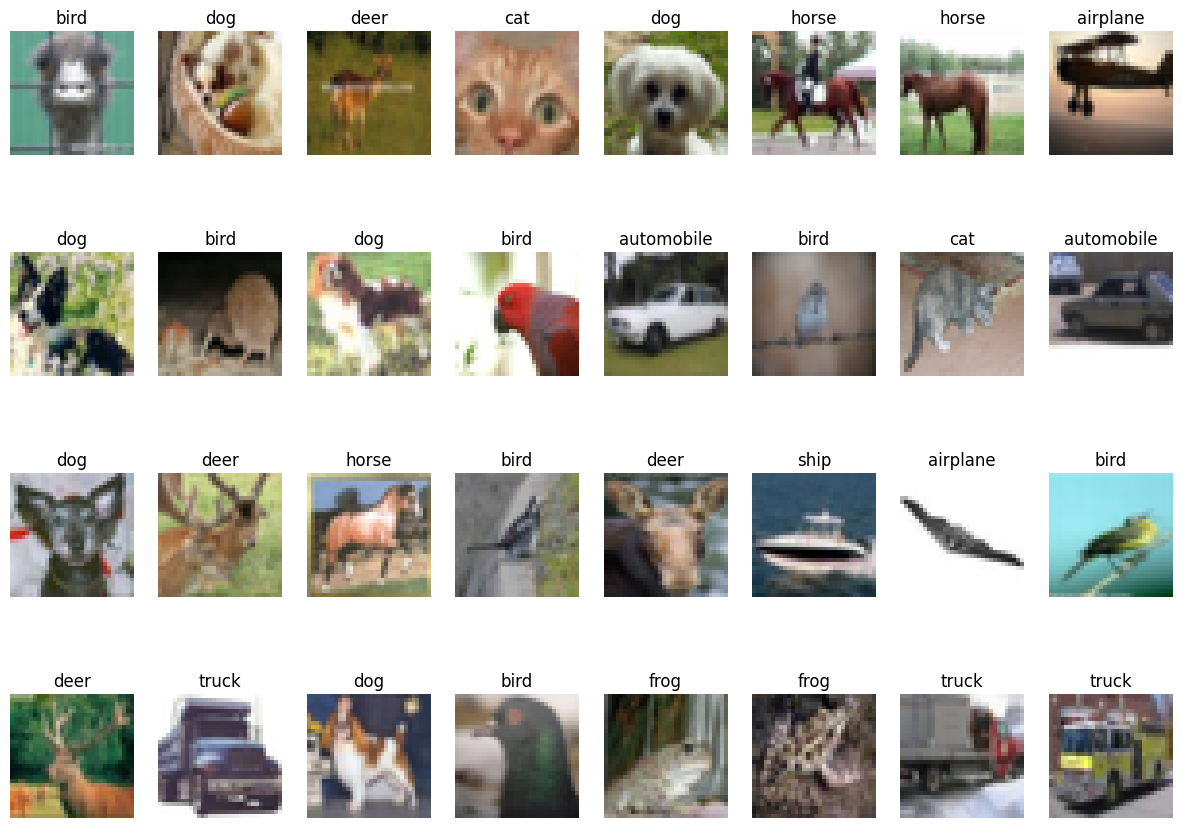

In [6]:
train = np.argmax(y_train, axis=1)
cols = 8
rows = 4
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid("off")
        ax.axis("off")
        ax.imshow(x_train[random_index, :])
        label = classes[train[random_index]]
        ax.set_title(label)
plt.show()

In [5]:
for i in range(y_train.shape[1]):
  print(f'Number of samples in training dataset for {classes[i]} class are : {np.count_nonzero(x_train[i])}')

Number of samples in training dataset for airplane class are : 3065
Number of samples in training dataset for automobile class are : 3072
Number of samples in training dataset for bird class are : 3072
Number of samples in training dataset for cat class are : 3072
Number of samples in training dataset for deer class are : 3061
Number of samples in training dataset for dog class are : 3071
Number of samples in training dataset for frog class are : 3072
Number of samples in training dataset for horse class are : 3072
Number of samples in training dataset for ship class are : 3072
Number of samples in training dataset for truck class are : 3072


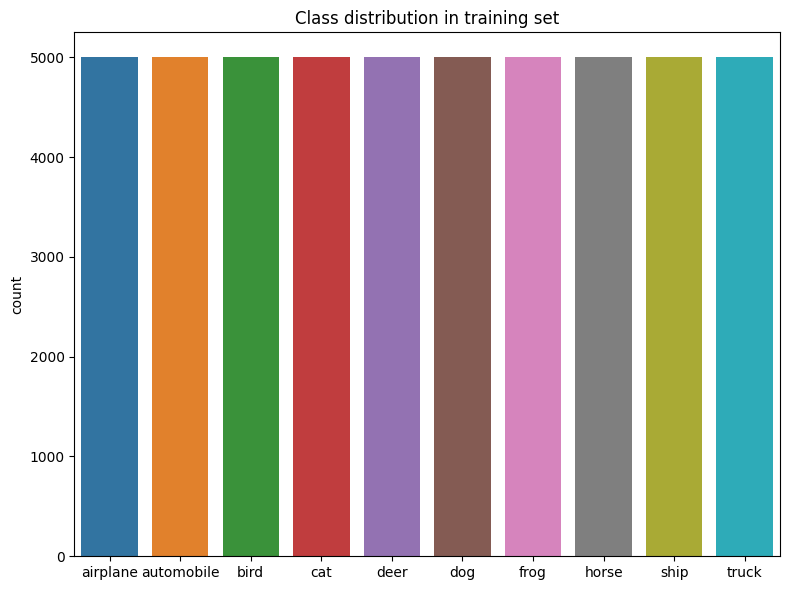

In [47]:
#Distribution for each class in train dataset

plt.figure(figsize=(8,6))
#sns.barplot( counts)#, legend = classes_name)
sns.countplot(x = np.argmax(y_train, axis = 1)).set(xticklabels = classes.values())
plt.title('Class distribution in training set')
plt.tight_layout()
plt.savefig(os.path.join(
                    os.getcwd(),
                    "data/Class distribution training set CIFAR10.jpg"
                ))
plt.show()

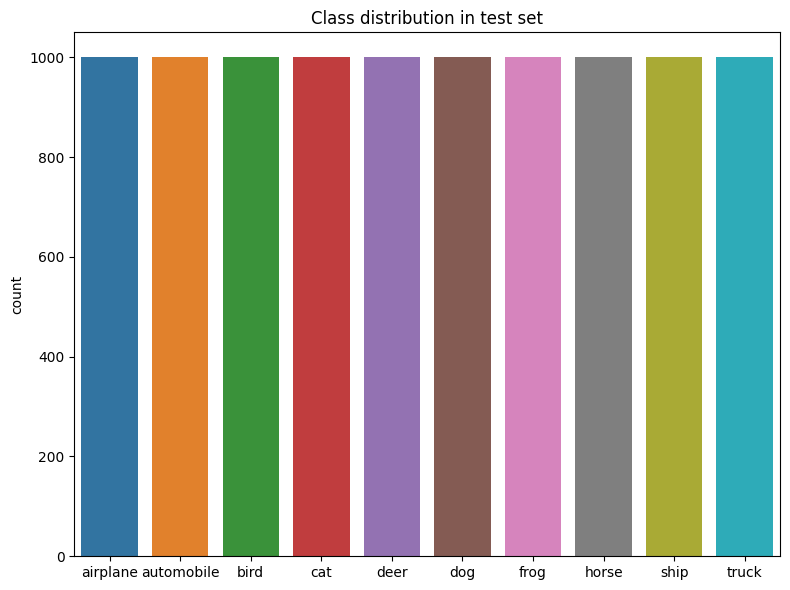

In [46]:
#Distribution for each class in test dataset
plt.figure(figsize=(8,6))
sns.countplot(x = np.argmax(y_test, axis = 1)).set(xticklabels = classes.values())
plt.title('Class distribution in test set')
plt.tight_layout()
plt.savefig(os.path.join(
                    os.getcwd(),
                    "data/Class distribution test set CIFAR10.jpg"
                ))
plt.show()

We can see that data in train and test set is balanced for each class, which means the number of samples  in the dataset for each class is approximately equal.

Having a balanced dataset is important because it can lead to:
1. Overfitting: when a class has much more samples than a minority class, the model can overfit to the majority class and is not able to recognize properly the minority class, due to under-sampling; this results in poor performance.
2. Accuracy: performance metrics can be misleading for imbalanced datasets. If a model predicts the majority class for all instances, it will achieve high accuracy even though it is not making any meaningful predictions for the under-sampled data.
3. Difficulty learning minority class patterns: With limited samples of the minority class, the model may struggle to identify the unique patterns that distinguish it from the majority class.

#LeNet5 Model

**LeNet-5** is a convolutional neural network (CNN) architecture introduced by Yann LeCun in 1998. It played a pivotal role in the advancement of image recognition and is considered a foundational model for modern CNN architectures.

It was specifically designed for the challenging task of handwritten digit recognition and achieved remarkable performance, becoming a benchmark for CNNs and influencing the development of deep learning models in general.

LeNet's significance lies in its pioneering role in demonstrating the effectiveness of CNNs for complex pattern recognition tasks. It introduced several key concepts and techniques that are still fundamental to modern CNN architectures, such as: **Convolutional layers, Pooling layers and Fully-Connected layers**

It played an important role for demostraiting the power of CNNs for image classification tasks with its simple and efficient architecture, compared to modern CNNs architectures.

The model is structured as follows:

1. **Input layer:** This layer receives the input image, typically a grayscale image of a handwritten digit.

2. **Convolutional layer 1:** This layer applies 6 5x5 convolution filters to the input image, producing 6 feature maps.

3. **Pooling layer 1:** This layer performs 2x2 max pooling on each feature map, reducing its dimensions and enhancing translational invariance.

4. **Convolutional layer 2:** This layer applies 16 5x5 convolution filters to the pooled feature maps, producing 16 feature maps.

5. **Pooling layer 2:** This layer performs 2x2 max pooling on each feature map, further reducing its dimensions.

6. **Fully connected layer 1:** This layer connects all neurons in the previous layer to 120 neurons, transforming the spatial feature maps into a vector representation.

7. **Fully connected layer 2:** This layer connects all neurons in the previous layer to 84 neurons, further processing the vector representation.

8. **Output layer:** This layer consists of 10 neurons, corresponding to the 10 possible handwritten digits (0-9), and produces the final classification out.


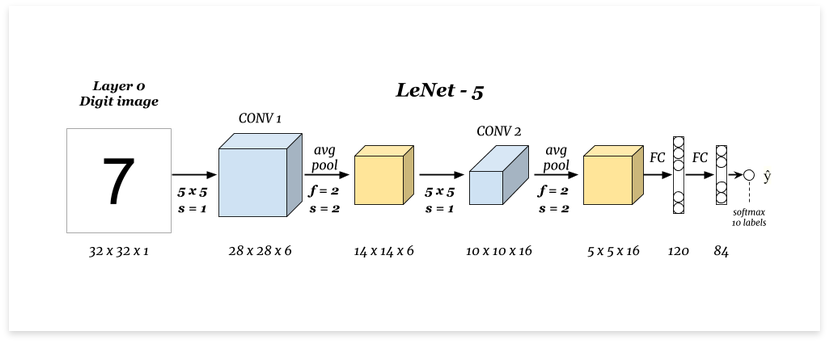

In this case we will evaluate the performance of the LeNet-5 Model for the CIFAR-10 dataset. As such, the input image will be a (32,32,3) RGB image and the output will consit of 10 neurons, corresponding to 10 possible classes.

Define model

In [48]:
def lenet5(input_shape: tuple, output_shape: int) -> Model:
    model = Sequential()
    model.add(Conv2D(6, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(16, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation = 'relu', kernel_initializer='he_normal' ))
    model.add(Dense(84, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(output_shape, activation = 'softmax', kernel_initializer='he_normal' ))
    sgd = optimizers.SGD(learning_rate=.005, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    model.summary()
    return model

In [49]:
#Load model
model = lenet5(x_train[1].shape, y_train.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [50]:
#Define hyperparameters
batch_size    = 128
epochs        = 200
iterations    = 391
num_classes   = 10
weight_decay  = 0.0001
model_type = "LeNet"

In [ ]:
#Define Learning Rate Scheduler
def scheduler(epoch):
    if epoch < 100:
        return 0.01
    if epoch < 150:
        return 0.005
    return 0.001

In [ ]:
# set callback
tb_cb = TensorBoard(log_dir='./models/lenet2', histogram_freq=0)
#change_lr = LearningRateScheduler(scheduler)
log_csv = CSVLogger(os.path.join(os.getcwd(), "/results/logs_%s.csv"%model_type), separator=",", append=False)
cbks = [tb_cb, log_csv]
# start train
print("[Info] Training model ...")
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test),
                    verbose=1)
# save model
save_dir = os.getcwd() + "/models"
filepath = os.path.join(save_dir, "lenet.h5")
model.save(filepath)

[Info] Training model ...
Epoch 1/200
391/391 [==============================] - 5s 9ms/step - loss: 1.9196 - accuracy: 0.2980 - val_loss: 1.7523 - val_accuracy: 0.3807
Epoch 2/200
391/391 [==============================] - 4s 9ms/step - loss: 1.5508 - accuracy: 0.4386 - val_loss: 1.5536 - val_accuracy: 0.4422
Epoch 3/200
391/391 [==============================] - 3s 7ms/step - loss: 1.4482 - accuracy: 0.4790 - val_loss: 1.4481 - val_accuracy: 0.4831
Epoch 4/200
391/391 [==============================] - 3s 7ms/step - loss: 1.3774 - accuracy: 0.5075 - val_loss: 1.3432 - val_accuracy: 0.5208
Epoch 5/200
391/391 [==============================] - 3s 7ms/step - loss: 1.3254 - accuracy: 0.5255 - val_loss: 1.3120 - val_accuracy: 0.5285
Epoch 6/200
391/391 [==============================] - 3s 6ms/step - loss: 1.2832 - accuracy: 0.5434 - val_loss: 1.2995 - val_accuracy: 0.5434
Epoch 7/200
391/391 [==============================] - 3s 9ms/step - loss: 1.2480 - accuracy: 0.5555 - val_loss: 1.3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
print("[Info] Evaluating model")

model = load_model('models/lenet.h5')
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
train_loss, train_acc = model.evaluate(x_train,  y_train, verbose=2)
# final accuracies
print('Training Accuracy', +train_acc)
print('Test Accuracy', +test_acc)

[Info] Evaluating model
313/313 - 3s - loss: 5.0677 - accuracy: 0.5547 - 3s/epoch - 8ms/step
1563/1563 - 17s - loss: 0.1200 - accuracy: 0.9574 - 17s/epoch - 11ms/step
Training Accuracy 0.957360029220581
Test Accuracy 0.5547000169754028


#Display LeNet Model Results

Model accuracy and loss is saved in logs_LeNet.csv file and the trained model was saved in lenet.h5 file

In [150]:
model_name = 'lenet.h5'
logs = 'logs_LeNet.csv'

##Accuracy and Loss curves

From the loss curve we see that the loss in the training set is decreasing to zero, meanwhile in the test set is increasing. Aditionally, from the accuracy plot we see that the accuracy in training set is increasisng towards 100% and reaches a maximum of 95%, by contrast, in the test set it settles down and stabilizes in 55%, which is significantly lower.

As such, we can see that the **model is overfitted**, that is, it has memorized the training data too well and is unable to generalize to new data. This means that the model will perform well on the training data but poorly on unseen data.



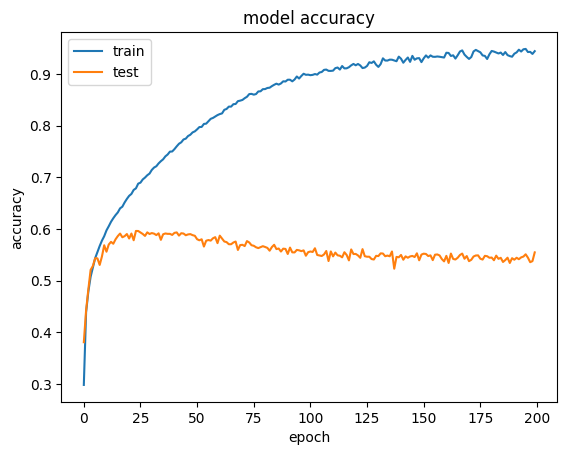

<Figure size 640x480 with 0 Axes>

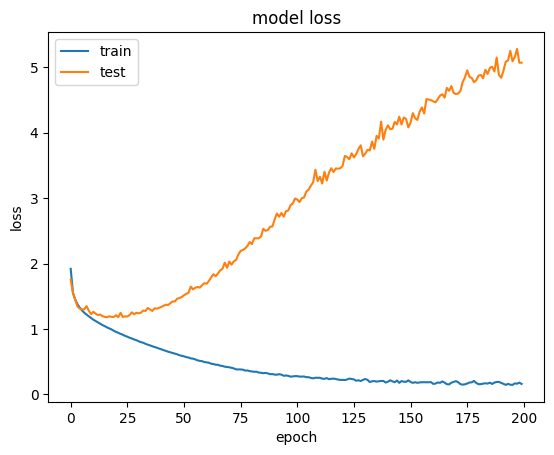

<Figure size 640x480 with 0 Axes>

In [57]:
plot_metrics(logs, model_name)

##Confusion matrix

From the confusion matrix we can see that the model is performing well identifying airplanes, automobiles, frogs, ships and turcks with and overall performance of roughly 60% and is performing poorly on the other classes.
For example, we see that it has troubles differentiating between cats and dogs, trucks and automobiles, deer and dogs, etc. This can be due to similarity between the classes and low resolution of the images.

313/313 [==============================] - 3s 9ms/step


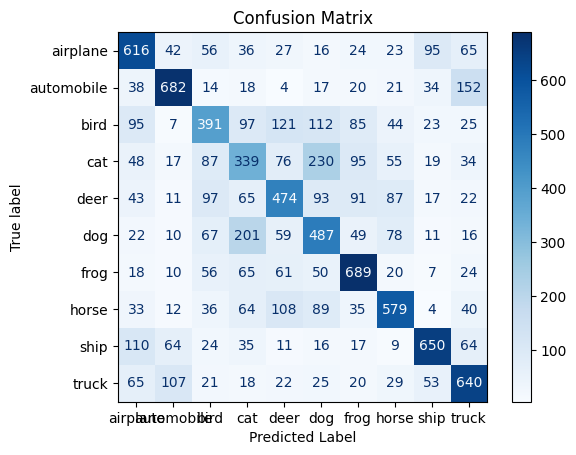

<Figure size 640x480 with 0 Axes>

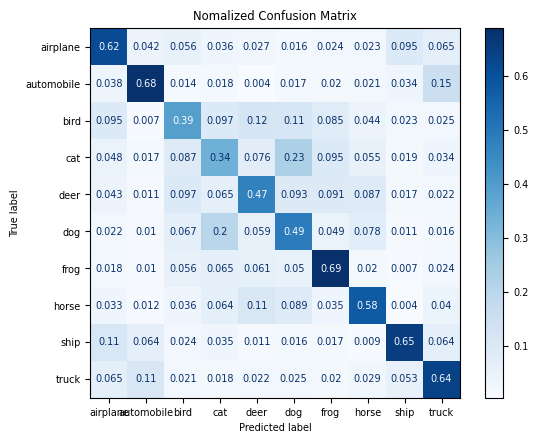

In [58]:
display_confusion_matrix(x_test, y_test, classes, model_name)

313/313 [==============================] - 3s 11ms/step


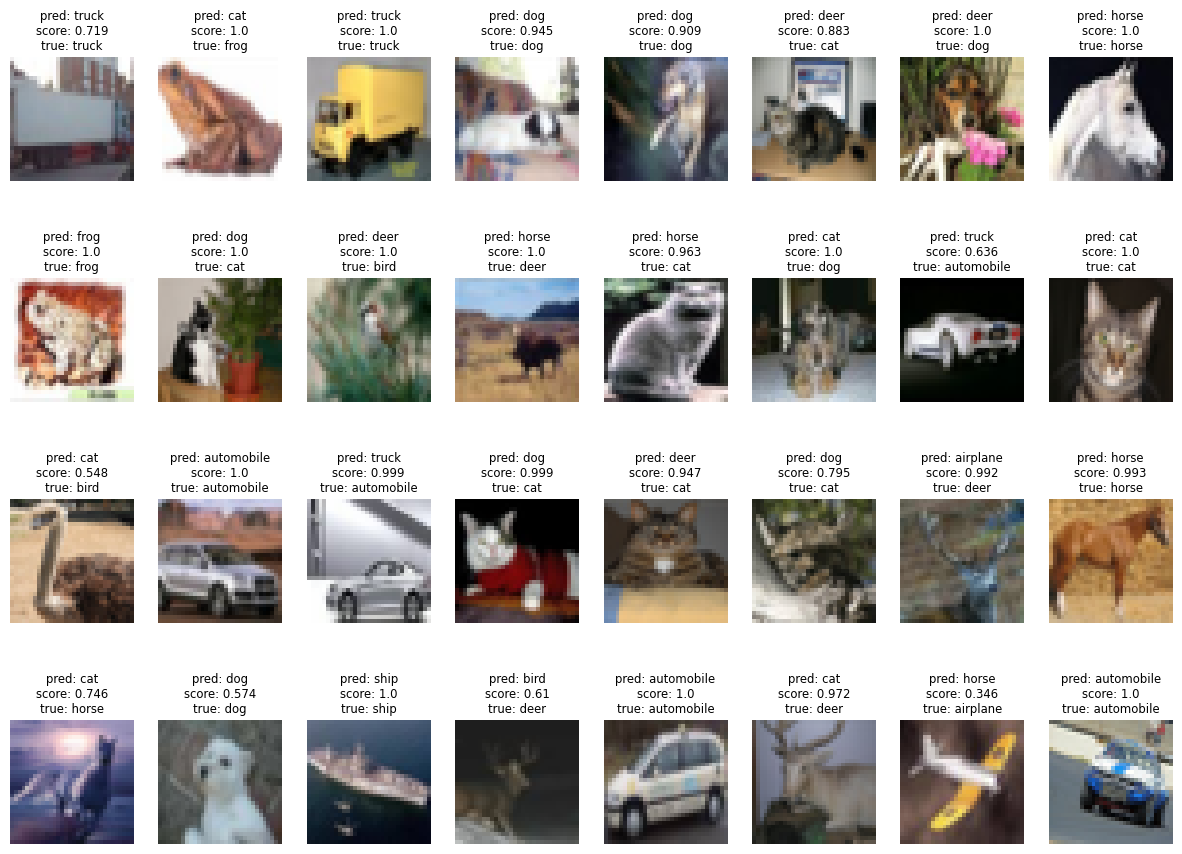

In [59]:
visualize_predictions(y_test, x_test,  classes, model_name)

##Layers visualitation

We will display the feature map of each convolutional layer, that is, the output of each layer after the kernels has been applied.

Visualizing feature maps provides insights into how a convolutional neural network (CNN) processes and interprets input images. Feature maps are generated at each layer of the CNN, representing the activation of the network's filters at different spatial scales.

The intuition behind is that feature maps closer to the input layer capture low-level features, such as edges and contours, while feature maps closer to the output layer capture high-level features, such as objects and shapes.

As the input image progresses through the convolutional layers, the network extracts and represents increasingly abstract features, gradually distilling the raw pixel information into more meaningful and higher-level representations.

As the network learns to identify relevant features, it becomes more selective in its activation patterns, focusing on the most discriminative features while suppressing less relevant ones. This **sparsity** is a desirable property as it contributes to the network's efficiency and generalization ability.

We provided as input image an airplane and we can see that the firsts convolutional layers start identifying somthing similar to the edges of the airplane, while discriminating the background. As the network progresses, it discards irrelevant pixel information while retaining and refining the features that are most indicative of the image's class. As such, it transforms the original input data into a more abstract representation that allows the recognition of that specific class. it also turns of many pixels that are irrelevant for the class recognition, focusing only on important patterns.


1/1 [==============================] - 0s 148ms/step


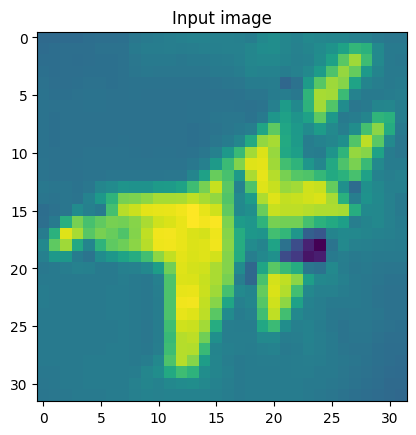

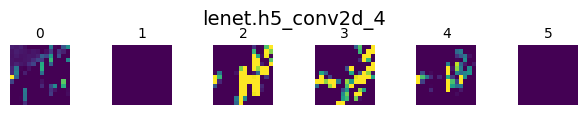

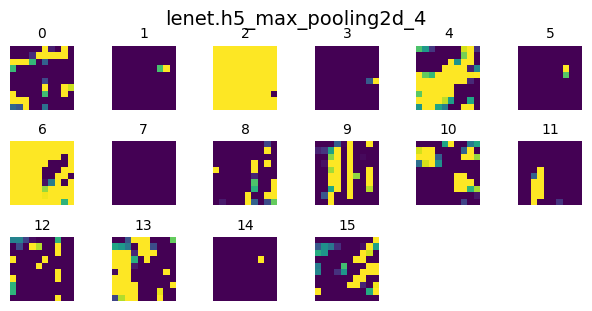

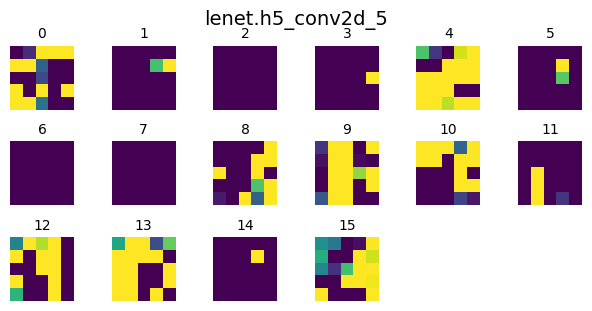

In [151]:
visualize_layers(x_test[10], 1, 6, model_name)

##Classification report

From the classification report we can see that it reaches an overall accuracy of 55% on the test set. While this accuracy is not ideal, it is still a reasonable performance given the relatively simple network architecture.

In [61]:
report(x_test, y_test, classes, model_name)

313/313 [==============================] - 3s 9ms/step
              precision  recall  f1-score     support
0              0.566176  0.6160  0.590038   1000.0000
1              0.708940  0.6820  0.695209   1000.0000
2              0.460542  0.3910  0.422931   1000.0000
3              0.361407  0.3390  0.349845   1000.0000
4              0.492212  0.4740  0.482934   1000.0000
5              0.429075  0.4870  0.456206   1000.0000
6              0.612444  0.6890  0.648471   1000.0000
7              0.612698  0.5790  0.595373   1000.0000
8              0.711939  0.6500  0.679561   1000.0000
9              0.591497  0.6400  0.614793   1000.0000
accuracy       0.554700  0.5547  0.554700      0.5547
macro avg      0.554693  0.5547  0.553536  10000.0000
weighted avg   0.554693  0.5547  0.553536  10000.0000


In [62]:
make_prediction(x_test, y_test, classes, model_name)

313/313 [==============================] - 3s 9ms/step
    Real  Real Class  Prediction Predict Class  Probability
0    3.0         cat         6.0          frog     0.999332
1    8.0        ship         8.0          ship     0.999990
2    8.0        ship         1.0    automobile     0.994326
3    0.0    airplane         1.0    automobile     0.779240
4    6.0        frog         6.0          frog     0.992389
5    6.0        frog         0.0      airplane     0.925940
6    1.0  automobile         5.0           dog     0.999926
7    6.0        frog         3.0           cat     0.804365
8    3.0         cat         3.0           cat     0.984890
9    1.0  automobile         1.0    automobile     1.000000
10   0.0    airplane         3.0           cat     0.861592
11   9.0       truck         9.0         truck     0.999748
12   5.0         dog         5.0           dog     0.663125
13   7.0       horse         7.0         horse     1.000000
14   9.0       truck         9.0         truc

#Improve the results

In orther to improve the results we will apply some technics that avoids overfitting and increases accuracy of the model.

1. **Data Augmentation:** This involves artificially increasing the size and diversity of the training data by applying transformations to the existing data. This can help the model learn more generalizable features and reduce its reliance on specific training examples. We will include random flipping, rotating, shearing, brightness, etc.

2. **Regularization:** penalize complex models, preventing them from overfitting the training data. We will include **L2 regularization**, which adds the square of the model's weights to the loss function, encouraging smoother and less overfitted models.

3. **Variable learning rate:** this is used to adjust the learning rate dynamically during training, rather than using a fixed learning rate throughout the process. This can help to escape from local minima in the loss surface, leading to better convergence and generalization performance.



In [ ]:
def scheduler(epoch):
    if epoch < 100:
        return 0.01
    if epoch < 150:
        return 0.005
    return 0.001

model_type = 'LeNet2'

    # build network
model = lenet5(x_train[1].shape, y_train.shape[1])


# set callback
tb_cb = TensorBoard(log_dir='./models/lenet2', histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
log_csv = CSVLogger(os.path.join(os.getcwd(), "logs_%s.csv"%model_type), separator=",", append=False)
cbks = [change_lr,tb_cb, log_csv]

# using real-time data augmentation
print('Using real-time data augmentation.')
datagen = data_augmenter()
#ImageDataGenerator(horizontal_flip=True,
        #width_shift_range=0.125,height_shift_range=0.125,fill_mode='constant',cval=0.)

datagen.fit(x_train)

# start train
history = model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test),
                    verbose=1)

# save model
model.save('models/lenet2')

170498071/170498071 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
print("[Info] Evaluating model")

model = load_model('models/lenet2.h5')
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
train_loss, train_acc = model.evaluate(x_train,  y_train, verbose=2)
# final accuracies
print('Training Accuracy', +train_acc)
print('Test Accuracy', +test_acc)

[Info] Evaluating model
313/313 - 4s - loss: 0.8685 - accuracy: 0.7215 - 4s/epoch - 14ms/step
1563/1563 - 14s - loss: 0.7200 - accuracy: 0.7679 - 14s/epoch - 9ms/step
Training Accuracy 0.7679200172424316
Test Accuracy 0.7214999794960022


#Display Results

Model accuracy and loss is saved in logs_LeNet2.csv file and the trained model was saved in lenet2.h5 file

In [152]:
model_name = 'lenet2.h5'
logs = 'logs_LeNet2.csv'

##Accuracy and Loss curves

From the loss curve we see that the loss in the training set is decreasing smoothly to zero and in the test set is doing the same. Aditionally, from the accuracy plot we see that the accuracy in training and test set is increasing and reaches a maximum of 76% and 72%, respectivily.

We also see some abrubt changes or 'jumps' in the curves that occurs due to the variable learning rate and helped improve both accuracy and loss.

We conclude that the model is no longer overfitted.



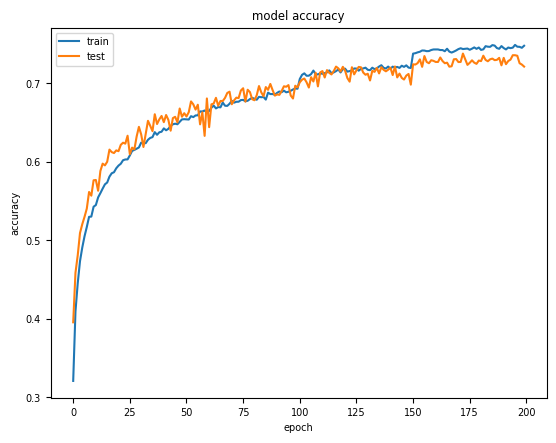

<Figure size 640x480 with 0 Axes>

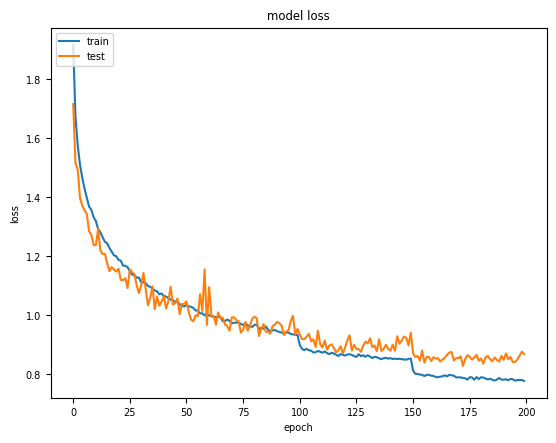

<Figure size 640x480 with 0 Axes>

In [68]:
plot_metrics(logs, model_name)

##Confusion matrix

From the confusion matrix we can see that the model is performing much better than the previous model. It is good identifying airplanes, automobiles, frogs, ships and turcks with and overall performance about 80% and is performing well on other classes compared to the previous model.

It has less issues differentiaing between an airplane and a truck, an automobile and a truck and a ship and an airplane. However, it has still some dificulties identiyinf correctly between animals and confuses cats with dogs or frogs, deers with frogs and birds with frogs.

However, it increased its overall performance.

313/313 [==============================] - 4s 13ms/step


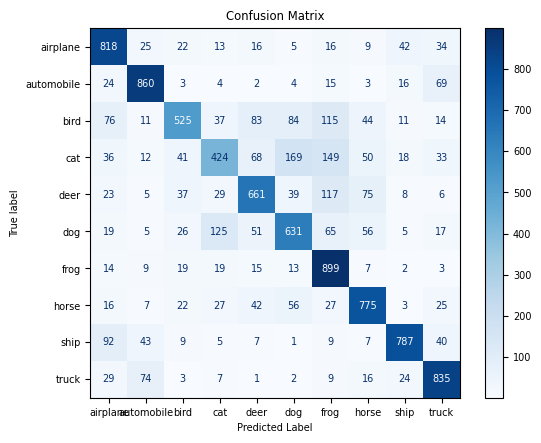

<Figure size 640x480 with 0 Axes>

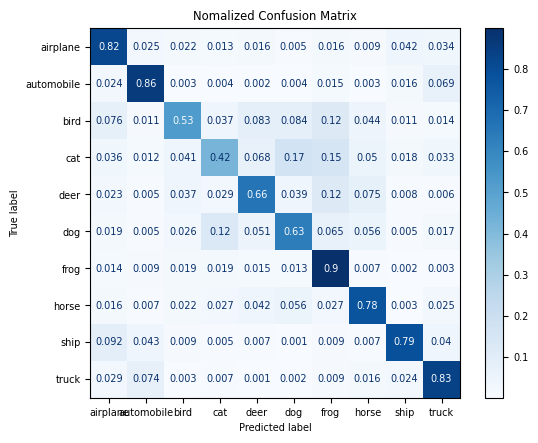

In [69]:
display_confusion_matrix(x_test, y_test, classes, model_name)

313/313 [==============================] - 4s 13ms/step


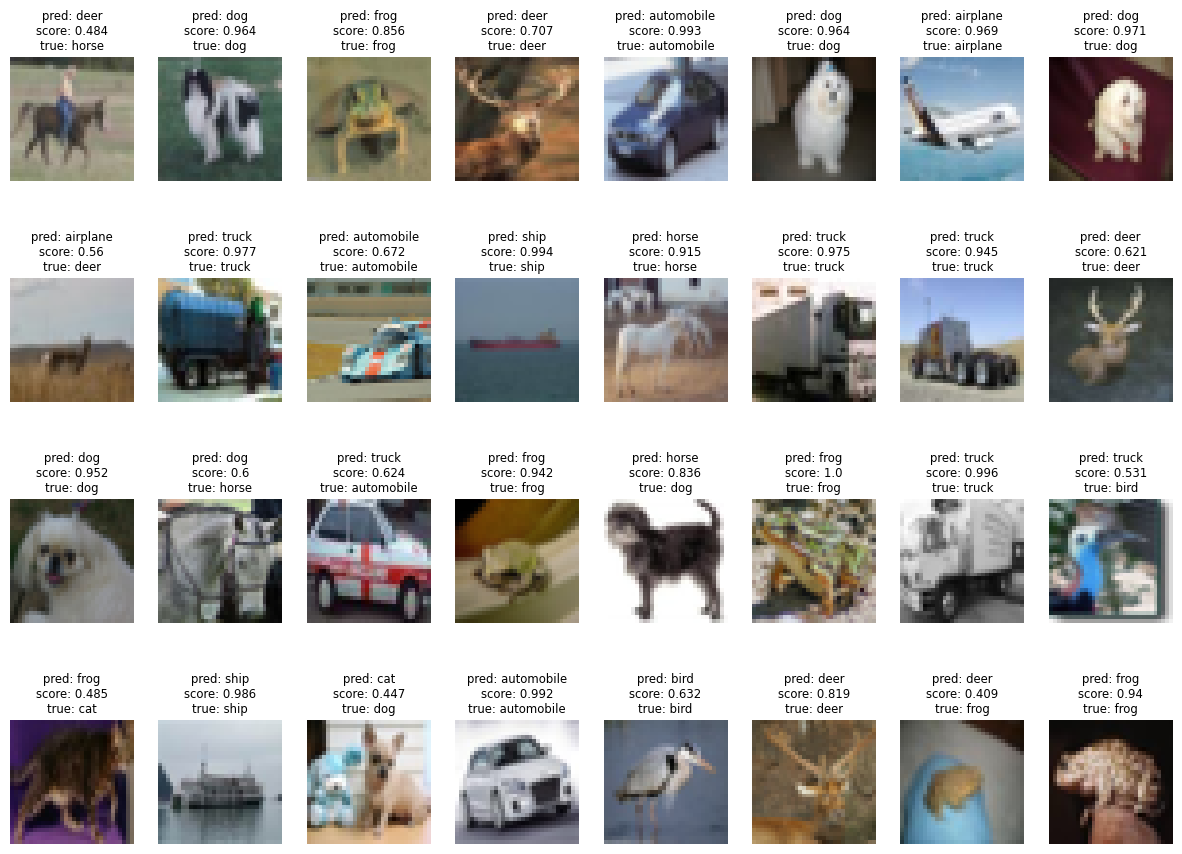

In [70]:
visualize_predictions(y_test, x_test,  classes, model_name)

##Layers visualitation


As the previous case, we provided as input image an airplane and we can see that the firsts convolutional layers start identifying  the edges and shape of the airplane and it can be more clearly seen than before. As the network progresses, it transforms the original image into a more abstract representation that allows the recognition of that specific class.


1/1 [==============================] - 0s 112ms/step


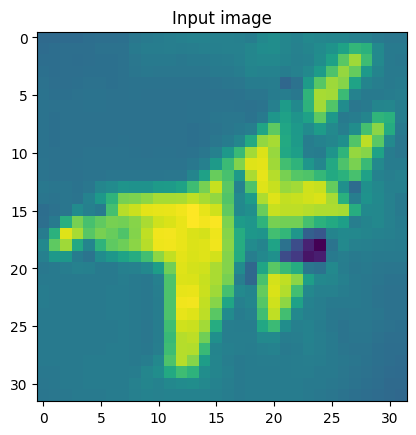

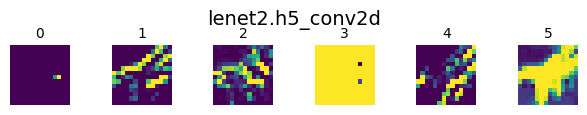

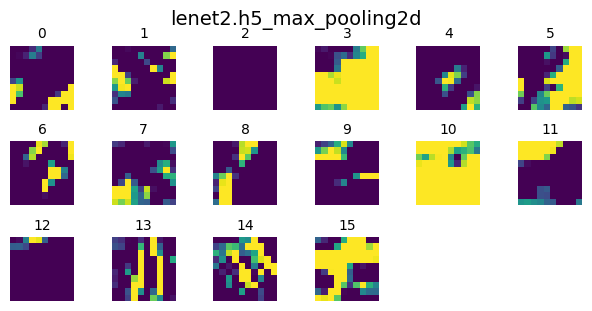

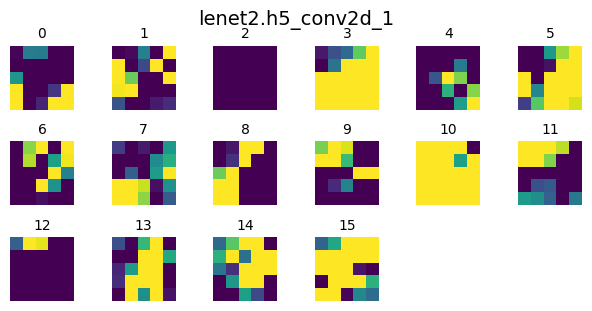

In [154]:
visualize_layers(x_test[10], 1, 6, model_name)

##Classification report

Achieving an overall accuracy of 72% on the test set indicates that the model correctly classifies 72% of the images in the test set. This is a significant improvement over the previous accuracy of 55%, suggesting that the techniques applied to avoid overfitting and increase accuracy were effective.

The weighted average precision, recall, and F1-scores are higher than the corresponding macro average scores. This indicates that the model is performing better on the majority classes than the minority classes.
The precision, recall, and F1-scores for all classes are above 50%, which suggests that the model is making more correct predictions than incorrect predictions for all classes.

This demonstrate that the model has learned to distinguish between the different classes reasonably well. However, it can be futher improved, and it would be worthwhile to further analyze the model's performance to identify any areas where it can be refined.

In [71]:
report(x_test, y_test, classes, model_name)

313/313 [==============================] - 4s 11ms/step
              precision  recall  f1-score     support
0              0.713165  0.8180  0.761993   1000.0000
1              0.818268  0.8600  0.838615   1000.0000
2              0.742574  0.5250  0.615114   1000.0000
3              0.614493  0.4240  0.501775   1000.0000
4              0.698732  0.6610  0.679342   1000.0000
5              0.628486  0.6310  0.629741   1000.0000
6              0.632653  0.8990  0.742668   1000.0000
7              0.743762  0.7750  0.759060   1000.0000
8              0.859170  0.7870  0.821503   1000.0000
9              0.776022  0.8350  0.804432   1000.0000
accuracy       0.721500  0.7215  0.721500      0.7215
macro avg      0.722733  0.7215  0.715424  10000.0000
weighted avg   0.722733  0.7215  0.715424  10000.0000


In [72]:
make_prediction(x_test, y_test, classes, model_name)

313/313 [==============================] - 3s 9ms/step
    Real  Real Class  Prediction Predict Class  Probability
0    3.0         cat         3.0           cat     0.862736
1    8.0        ship         8.0          ship     0.998661
2    8.0        ship         8.0          ship     0.496167
3    0.0    airplane         1.0    automobile     0.608371
4    6.0        frog         6.0          frog     0.990477
5    6.0        frog         6.0          frog     0.675938
6    1.0  automobile         1.0    automobile     0.889432
7    6.0        frog         6.0          frog     0.821054
8    3.0         cat         6.0          frog     0.472935
9    1.0  automobile         1.0    automobile     0.887910
10   0.0    airplane         0.0      airplane     0.863044
11   9.0       truck         9.0         truck     0.998239
12   5.0         dog         4.0          deer     0.635868
13   7.0       horse         7.0         horse     0.999679
14   9.0       truck         9.0         truc

#Conclusion


Using the LeNet-5 model for the CIFAR-10 dataset proved to be successful, as it initially achieved a promising accuracy of 55%. However, further improvements were made by applying regularization techniques, data augmentation, and a variable learning rate, leading to a significant boost in accuracy to 72%. This demonstrates the effectiveness of these strategies in addressing the issue of overfitting and enhancing the model's generalization ability.

The initial accuracy of 55% indicates that the LeNet-5 model had the potential to capture the underlying patterns and features in the CIFAR-10 dataset. However, the overfitting issue prevented the model from fully utilizing this potential and resulted in suboptimal performance.

By applying regularization techniques, the complexity of the model was controlled, reducing its tendency to memorize the training data and improving its ability to generalize to unseen data. Data augmentation, on the other hand, increased the diversity of the training data, allowing the model to learn more robust and generalizable features. The variable learning rate approach further refined the model's optimization process, enabling it to adjust its learning behavior dynamically and avoid getting stuck in local minima.

The combination of these techniques effectively addressed the overfitting issue, resulting in a significant improvement in accuracy from 55% to 72%.

However, the cost of this performance was an increased trainign time. Initially it tok about 10 minutes to train the model but the second case took about 2 hours. This is mainly due to the ```ImageDataGenerator``` class used for the data augmentation.

To improve the performance, we can also consider to select another model architecture that suit better for this task or use hyperparameter optimization to find the right parameters that minimizes loss and maximises accuracy.


